# Homework 4 - Trade Flow
By: Alex Huang

Date: February 8, 2024

UChicago ID: 12408153

## Imports and Config

In [44]:
# Operating
import os
import shutil
import platform
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data
import statsmodels.api as sm
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import scipy as sp

# Typing
from typing import Union

import warnings
warnings.filterwarnings("ignore")

In [10]:
# Configuration
pd.set_option('display.float_format', '{:,.4f}'.format)
plt.style.use('ggplot')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.figure(figsize=(12, 6))

TIMESTAMP_COL_NAME = 'timestamp_utc_nanoseconds'

<Figure size 1200x600 with 0 Axes>

## Functions

In [11]:
class Compute:
    def lagged_tradeflow(timeseries: pd.DataFrame, time_column_name: str, volume_column_name: str, side_column_name: str, lag: int):
        directional_volume = timeseries[[time_column_name, volume_column_name, side_column_name]]
        directional_volume['directional_volume'] = (directional_volume[volume_column_name] * directional_volume[side_column_name])
        directional_volume = directional_volume.groupby(time_column_name)['directional_volume'].sum().to_frame()
        directional_volume = directional_volume.sort_index()
        org_cumsum = directional_volume['directional_volume'].cumsum()
        org_cumsum.name = 'cumsum'


        lagged_cumsum = org_cumsum.copy()
        lagged_cumsum.index = org_cumsum.index + (lag + 1)
        lagged_cumsum = lagged_cumsum.reindex(org_cumsum.index, method='ffill')
        lagged_cumsum.name = f'{lag}_lag_cumsum'

        new_timeseries = pd.concat([directional_volume, org_cumsum, lagged_cumsum], axis=1)
        new_timeseries[f'trailing_{lag}_tradeflow'] = org_cumsum - lagged_cumsum 
        return new_timeseries
    
    def forward_returns(timeseries: pd.DataFrame, time_column_name: str, price_column_name: str, volume_column_name, amt_lookfwd: int):
        avg_price = timeseries.groupby(time_column_name).agg({f'{price_column_name}': 'mean', f'{volume_column_name}': 'sum'}).sort_index().rename(columns={f'{price_column_name}': 'price', f'{volume_column_name}': 'total_volume'})
        # display(avg_price)
        forward_price = avg_price['price'].copy()
        forward_price.index = avg_price.index - (amt_lookfwd)
        # display(forward_price)

        forward_price = forward_price.reindex(avg_price.index, method='ffill')
        forward_price.name = f'{amt_lookfwd}_forward_price'
        # display(forward_price)
        forward_returns = forward_price / avg_price['price'] - 1
        forward_returns.name = f'{amt_lookfwd}_foward_returns'

        return pd.concat([avg_price, forward_price, forward_returns], axis=1)

        

In [85]:
class PlotDynamics:
    def plot_returns_ts_hist(returns_series: pd.Series, ticker_symbol: str, figsize: tuple=(12,6), bins: int=20, use_steps_post: bool=False):
        if not isinstance(returns_series, pd.Series): raise TypeError("returns_series must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("returns_series must be type str.")
        # if not pd.api.types.is_datetime64_any_dtype(returns_series.index): raise TypeError("returns_series.index must be datetime type.")
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        if use_steps_post:
            ax1.plot(returns_series.index, returns_series.values, drawstyle='steps-post')
        else:
            ax1.plot(returns_series.index, returns_series.values)
        ax1.set_title(f'{ticker_symbol} Returns Time Series')
        ax1.set_xlabel(f'Time')
        ax1.set_ylabel(f'{ticker_symbol} Returns')

        ax2.hist(returns_series.values, bins=bins, color='skyblue', edgecolor='black')
        ax2.set_title(f'{ticker_symbol} Returns Histogram')
        ax2.set_xlabel(f'Returns')
        ax2.set_ylabel(f'{ticker_symbol} Returns Frequency')

        plt.tight_layout()
        plt.show()

    def plot_price_volume(ticker_df: pd.DataFrame, ticker_symbol: str, y1_label: str="Adjusted Close Price", y2_label: str="Adjusted Volume", x_label: str="Time", figsize: tuple=(12,6), price_column_name: str='adj_close', volume_column_name: str='adj_volume', use_steps_post: bool=False):
        if not isinstance(ticker_df, pd.DataFrame): raise TypeError("ticker_df must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("ticker_symbol must be type str.")
        if price_column_name not in ticker_df.columns: raise KeyError(f"'{price_column_name}' not found in dataframe.")
        if volume_column_name not in ticker_df.columns: raise KeyError(f"'{volume_column_name}' not found in dataframe.")
        # if not pd.api.types.is_datetime64_any_dtype(ticker_df.index): raise TypeError("ticker_df.index must be datetime type.")

        fig, ax1 = plt.subplots(figsize=figsize)

        # Adjusted Clost Price
        if use_steps_post:
            ax1.plot(ticker_df.index, ticker_df[f'{price_column_name}'], label=y1_label, color='blue', drawstyle='steps-post')
        else:
            ax1.plot(ticker_df.index, ticker_df[f'{price_column_name}'], label=y1_label, color='blue')
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(y1_label, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend(loc='upper left')

        # Volume
        ax2 = ax1.twinx()
        if use_steps_post:
            ax2.plot(ticker_df.index, ticker_df[f'{volume_column_name}'], label=y2_label, color='green', alpha=0.3, drawstyle='steps-post')
        else:
            ax2.plot(ticker_df.index, ticker_df[f'{volume_column_name}'], label=y2_label, color='green', alpha=0.3)
        ax2.set_ylabel(y2_label, color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.legend(loc='upper right')

        # Show the plot
        plt.title(f'{ticker_symbol} Price and Volume')
        plt.show()
    

    def plot_multiple_ts(series_to_plot: Union[list[pd.Series], pd.Series], series_labels: Union[list[str], str], ylabel: str="Values", xlabel: str="Date", title: str="Time Series", figsize: tuple=(12,6), alphas: list[float]=None):
        # Perform type checking
        if not isinstance(xlabel, str): raise TypeError("xlabel must be type str.")
        if not isinstance(ylabel, str): raise TypeError("ylabel must be type str.")
        if not isinstance(title, str): raise TypeError("title must be type str.")

        if alphas is None: alphas = [1] * len(series_to_plot)

        
        plt.figure(figsize=figsize)
        if isinstance(series_to_plot, list) and isinstance(series_labels, list):
            series: pd.Series
            for series, label, alpha in zip(series_to_plot, series_labels, alphas):
                if isinstance(series, pd.Series) and isinstance(label, str):
                    plt.plot(series.index, series.values, label=label, alpha=alpha)
                else:
                    raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")
        elif isinstance(series_to_plot, pd.Series) and isinstance(series_labels, str):
            series: pd.Series = series_to_plot
            label: str = series_labels
            alpha: float = alphas[0]
            plt.plot(series.index, series.values, label=label, alpha=alpha)
        else:
            raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()

    def plot_pnl_trading_strategy(return_spread_df, sl_no_tsl_strat_pnl_pos_df, pl_series):
        line_alpha = 0.5
        box_alpha = 0.2
        fig, ax1 = plt.subplots()

        # Plot the first data on the primary y-axis
        ax1.scatter(return_spread_df.index, return_spread_df[f'{Parameters.M}_day_returns_spread'], color='gray', s=5)
        # ax1.plot(return_spread_df.index, return_spread_df[f'{Parameters.M}_day_returns_spread'], color='gray', alpha=line_alpha, label="Return Spread")
        ax1.set_xlabel('X-axis')
        ax1.set_ylabel('Return Spread', color='gray')
        ax1.axhline(y=Parameters.S, color='r', linestyle='--', label='Stop Limit', alpha=box_alpha)
        ax1.axhline(y=-Parameters.S, color='r', linestyle='--', alpha=box_alpha)
        plt.legend(loc='upper right')

        ax1.fill_between(return_spread_df.index, y1=Parameters.J, y2=Parameters.G, color='gray', alpha=box_alpha)
        ax1.fill_between(return_spread_df.index, y1=-Parameters.G, y2=-Parameters.J, color='gray', alpha=box_alpha)

        # TRADES FROM SIGNAL
        # prev_signal = 0
        # prev_date = None
        # for date, signal in signal_series.items():
        #     if signal != prev_signal and prev_signal == 0:
        #         prev_date = date
        #     elif signal != prev_signal and prev_signal != 0 and prev_date is not None:
        #         ax1.fill_betweenx(y=np.arange(
        #             np.nanmin(return_spread_df[f'{Parameters.M}_day_returns_spread']),
        #             np.nanmax(return_spread_df[f'{Parameters.M}_day_returns_spread']) + 1
        #         ), x1=prev_date, x2=date, color='red', alpha=box_alpha
        #         )
        #         prev_date = None
        #     prev_signal = signal

        # TRADES FROM HOLDINGS
        holdings_df = sl_no_tsl_strat_pnl_pos_df[[f'{SpreadTicker.ticker1}', f'{SpreadTicker.ticker2}']]
        prev_holding = 0
        prev_date = None
        for date, holding in holdings_df[f'{SpreadTicker.ticker1}'].items():
            if holding != prev_holding and prev_holding == 0:
                prev_date = date
            elif holding != prev_holding and prev_holding != 0 and prev_date is not None:
                ax1.fill_betweenx(y=np.arange(
                    np.nanmin(return_spread_df[f'{Parameters.M}_day_returns_spread']),
                    np.nanmax(return_spread_df[f'{Parameters.M}_day_returns_spread']) + 1
                ), x1=prev_date, x2=date, color='green', alpha=box_alpha
                )
                prev_date = None
            prev_holding = holding


        # Create a second y-axis (twin axes)
        ax2 = ax1.twinx()
        ax2.plot(pl_series.index, pl_series, color='green', label='PnL', alpha=line_alpha)
        ax2.set_ylabel('PnL', color='green')

        # Customize the plot
        plt.title('Strategy PnL Overlay on Spread and Parameters')
        plt.legend(loc='upper left')

        # Show the plot
        plt.show()

    def plot_regression_statistics(X: pd.Series, y: pd.Series, use_bias: bool=True, title: str="Regression Plot"):
        if use_bias:
            new_X = sm.add_constant(X)
        else:
            new_X = X

        model = sm.OLS(y, new_X)
        results = model.fit()
        predicted_values = results.predict(new_X)

        plt.scatter(X, y, label='Data', alpha=0.5)

        # Plot the regression line
        plt.plot(X, predicted_values, color='blue', label='Regression Line')

        # Add labels and legend
        plt.xlabel(X.name)
        plt.ylabel(y.name)
        plt.title(title)
        plt.legend()

        # Show plot
        plt.show()
        display(results.summary())



# Testing Compute.lagged_tradeflow()

In [13]:
# data = {
#     'time': [1,3,5,6,7,9,12],
#     'vol':  [5,2,3,4,1,7,10],
#     'side': [1,1,-1,1,1,-1,-1]
# }
data = {
    'time': [0] + [i for i in range(3,21,2)],
    'vol': [1] * 10,
    'side': list(range(1,11))
}
# data = {
#     'time': list(range(10)),
#     'vol': list(range(1,11)),
#     'side': [1] * 10
# }
data = pd.DataFrame(data)
data
Compute.lagged_tradeflow(data, 'time', 'vol', 'side', 2)

,directional_volume,cumsum,2_lag_cumsum,trailing_2_tradeflow
time,,,,
0,1,1,NaN,NaN
3,2,3,1.0000,2.0000
5,3,6,1.0000,5.0000
7,4,10,3.0000,7.0000
9,5,15,6.0000,9.0000
11,6,21,10.0000,11.0000
13,7,28,15.0000,13.0000
15,8,36,21.0000,15.0000
17,9,45,28.0000,17.0000


In [14]:
import pandas as pd

# Example left and right series
left_series = pd.Series([1, 2, 3], index=[0, 2, 6])
right_series = pd.Series([10, 20, 30], index=[1, 3, 5])
display(left_series)
display(right_series)
# Reindex the left series using the index of the right series
merged_series = left_series.reindex(right_series.index, method='ffill')

# Resulting merged series
print(merged_series)


0    1
2    2
6    3
dtype: int64

1    10
3    20
5    30
dtype: int64

1    1
3    2
5    2
dtype: int64


# Testing Forward Returns

In [15]:
data = {
    'time': list(range(1,21,2)),
    'price': list(range(1,11))
}

data = pd.DataFrame(data)


# Table of Contents

## I. Introduction: Overview and Objective

## II. Gathering Data: Fetching, Filtering, Cleaning, and Configuration

In [16]:
book_btc_usd_df = pd.read_csv(r'./data/book_narrow_BTC-USD_2023.delim', sep='\t')
book_eth_btc_df = pd.read_csv(r'./data/book_narrow_ETH-BTC_2023.delim', sep='\t')
book_eth_usd_df = pd.read_csv(r'./data/book_narrow_ETH-USD_2023.delim', sep='\t')
trades_btc_usd_df = pd.read_csv(r'./data/trades_narrow_BTC-USD_2023.delim', sep='\t')
trades_eth_btc_df = pd.read_csv(r'./data/trades_narrow_ETH-BTC_2023.delim', sep='\t')
trades_eth_usd_df = pd.read_csv(r'./data/trades_narrow_ETH-USD_2023.delim', sep='\t')

In [17]:
book_btc_usd_df = book_btc_usd_df.sort_values(TIMESTAMP_COL_NAME)
book_eth_btc_df = book_eth_btc_df.sort_values(TIMESTAMP_COL_NAME)
book_eth_usd_df = book_eth_usd_df.sort_values(TIMESTAMP_COL_NAME)
trades_btc_usd_df = trades_btc_usd_df.sort_values(TIMESTAMP_COL_NAME)
trades_eth_btc_df = trades_eth_btc_df.sort_values(TIMESTAMP_COL_NAME)
trades_eth_usd_df = trades_eth_usd_df.sort_values(TIMESTAMP_COL_NAME)

In [18]:
train_split_portion = 0.4

# Splitting book_btc_usd_df
train_book_btc_usd_df = book_btc_usd_df.iloc[:int(book_btc_usd_df.shape[0] * train_split_portion)]
test_book_btc_usd_df = book_btc_usd_df.iloc[int(book_btc_usd_df.shape[0] * train_split_portion):]

# Splitting book_eth_btc_df
train_book_eth_btc_df = book_eth_btc_df.iloc[:int(book_eth_btc_df.shape[0] * train_split_portion)] 
test_book_eth_btc_df = book_eth_btc_df.iloc[int(book_eth_btc_df.shape[0] * train_split_portion):]

# Splitting book_eth_usd_df
train_book_eth_usd_df = book_eth_usd_df.iloc[:int(book_eth_usd_df.shape[0] * train_split_portion)] 
test_book_eth_usd_df = book_eth_usd_df.iloc[int(book_eth_usd_df.shape[0] * train_split_portion):]

# Splitting trades_btc_usd_df
train_trades_btc_usd_df = trades_btc_usd_df.iloc[:int(trades_btc_usd_df.shape[0] * train_split_portion)] 
test_trades_btc_usd_df = trades_btc_usd_df.iloc[int(trades_btc_usd_df.shape[0] * train_split_portion):]

# Splitting trades_eth_btc_df
train_trades_eth_btc_df = trades_eth_btc_df.iloc[:int(trades_eth_btc_df.shape[0] * train_split_portion)] 
test_trades_eth_btc_df = trades_eth_btc_df.iloc[int(trades_eth_btc_df.shape[0] * train_split_portion):]

# Splitting trades_eth_usd_df
train_trades_eth_usd_df = trades_eth_usd_df.iloc[:int(trades_eth_usd_df.shape[0] * train_split_portion)] 
test_trades_eth_usd_df = trades_eth_usd_df.iloc[int(trades_eth_usd_df.shape[0] * train_split_portion):]


In [19]:
train_book_eth_usd_df.head()

,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,1629780000,1629670000,613579740,46580250,1629790000,1629660000,920369620,40425010,1674521275215127000,1674521271006006000,"1,629,725,000.0000"
1,1629780000,1629670000,613579740,46580250,1629790000,1629660000,920369620,125425010,1674521275215372000,1674521271008923000,"1,629,725,000.0000"
2,1629780000,1629670000,613579740,346580250,1629790000,1629660000,920369620,125425010,1674521275216940000,1674521271013030000,"1,629,725,000.0000"
3,1629780000,1629670000,613579740,334765040,1629790000,1629660000,920369620,125425010,1674521275236165000,1674521271071902000,"1,629,725,000.0000"
4,1629770000,1629670000,92158690,334765040,1629780000,1629660000,613579740,125425010,1674521275257733000,1674521271167792000,"1,629,720,000.0000"


In [20]:
train_trades_btc_usd_df.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1674521267814309000,1674521267874527000,22970120000,87069600,-1
1,1674521267814046000,1674521267874527000,22970150000,25797600,-1
2,1674521267817981000,1674521267878712000,22970120000,10,-1
3,1674521267822734000,1674521267886114000,22969160000,217683140,-1
4,1674521274845338000,1674521268676444000,22969840000,10000000,1


In [21]:
train_trades_btc_usd_df.columns

Index(['received_utc_nanoseconds', 'timestamp_utc_nanoseconds',
       'PriceMillionths', 'SizeBillionths', 'Side'],
      dtype='object')

## III.

### Price Dynamics

In [37]:
LAGGED_TRADEFLOW_TIME = 5e9
temp = Compute.lagged_tradeflow(trades_btc_usd_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME)
temp.dropna()

C:\Users\Alex\AppData\Local\Temp\ipykernel_108716\209954064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directional_volume['directional_volume'] = (directional_volume[volume_column_name] * directional_volume[side_column_name])


,directional_volume,cumsum,5000000000.0_lag_cumsum,trailing_5000000000.0_tradeflow
timestamp_utc_nanoseconds,,,,
1674521272916860000,23940820,2558831670,"-330,550,350.0000","2,889,382,020.0000"
1674521273132412000,87057780,2645889450,"-330,550,350.0000","2,976,439,800.0000"
1674521273160751000,1249870,2647139320,"-330,550,350.0000","2,977,689,670.0000"
1674521274249361000,11039540,2658178860,"48,705,740.0000","2,609,473,120.0000"
1674521275377409000,-219840,2657959020,"633,026,130.0000","2,024,932,890.0000"
...,...,...,...,...
1674661801477570000,920730,326651411740,"327,743,699,580.0000","-1,092,287,840.0000"
1674661801543105000,-335000000,326316411740,"327,743,699,580.0000","-1,427,287,840.0000"
1674661801601688000,-50000000,326266411740,"327,743,699,580.0000","-1,477,287,840.0000"


In [39]:
import statsmodels.api as sm

# Assuming temp['trailing_5000000000.0_tradeflow'] and fr_trades_btc_usd_df['5000000000.0_foward_returns'] are your dependent and independent variables respectively
X = sm.add_constant(temp['trailing_5000000000.0_tradeflow']/1e9)  # Add a constant term for the intercept
y = fr_trades_btc_usd_df['5000000000.0_foward_returns']

data = pd.merge(X, y, how='outer', left_index=True, right_index=True).dropna()

X = data.iloc[:,:-1]
y= data.iloc[:, -1]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:     5000000000.0_foward_returns   R-squared:                       0.000
Model:                                     OLS   Adj. R-squared:                  0.000
Method:                          Least Squares   F-statistic:                     83.11
Date:                         Wed, 07 Feb 2024   Prob (F-statistic):           7.79e-20
Time:                                 22:08:03   Log-Likelihood:             2.5819e+06
No. Observations:                       369458   AIC:                        -5.164e+06
Df Residuals:                           369456   BIC:                        -5.164e+06
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [22]:
FORWARD_RETURN_TIME_INTERVAL = 5e9
fr_trades_btc_usd_df = Compute.forward_returns(trades_btc_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
fr_trades_eth_btc_df = Compute.forward_returns(trades_eth_btc_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
fr_trades_eth_usd_df = Compute.forward_returns(trades_eth_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)


In [23]:
fr_trades_btc_usd_df

,price,total_volume,5000000000.0_forward_price,5000000000.0_foward_returns
timestamp_utc_nanoseconds,,,,
1674521267874527000,"22,970,135,000.0000",112867200,"22,972,960,000.0000",0.0001
1674521267878712000,"22,970,120,000.0000",10,"22,972,960,000.0000",0.0001
1674521267886114000,"22,969,160,000.0000",217683140,"22,972,960,000.0000",0.0002
1674521268676444000,"22,969,864,000.0000",271735050,"22,974,210,000.0000",0.0002
1674521268812951000,"22,967,670,000.0000",1318360,"22,974,210,000.0000",0.0003
...,...,...,...,...
1674661801477570000,"22,573,080,000.0000",920730,"22,570,920,000.0000",-0.0001
1674661801543105000,"22,571,970,000.0000",335000000,"22,570,920,000.0000",-0.0000
1674661801601688000,"22,570,920,000.0000",50000000,"22,570,920,000.0000",0.0000


#### BTC-USD Pair Dynamics

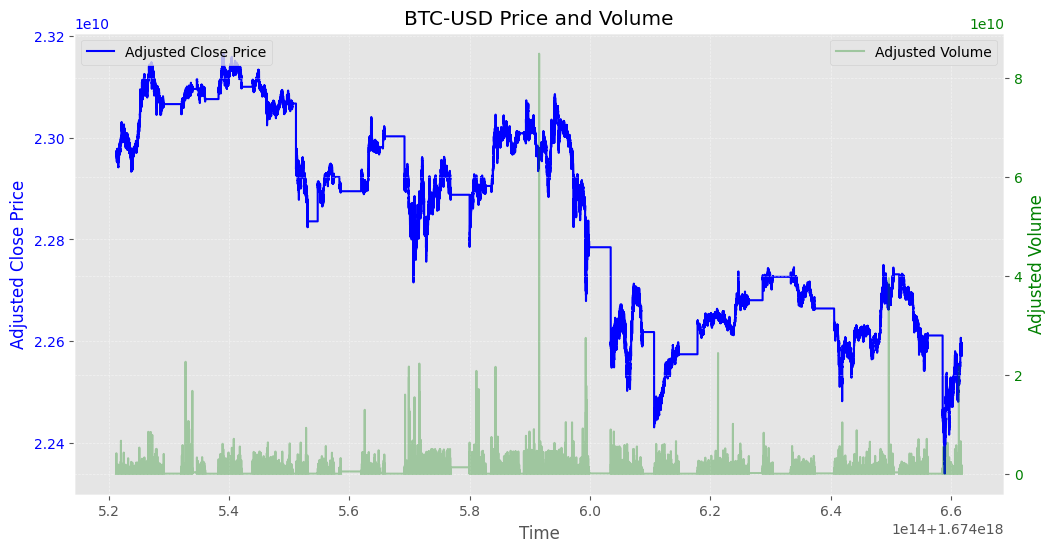

In [24]:
PlotDynamics.plot_price_volume(fr_trades_btc_usd_df, 'BTC-USD', price_column_name='price', volume_column_name='total_volume', use_steps_post=True)

#### ETH-BTC Pair Dynamics

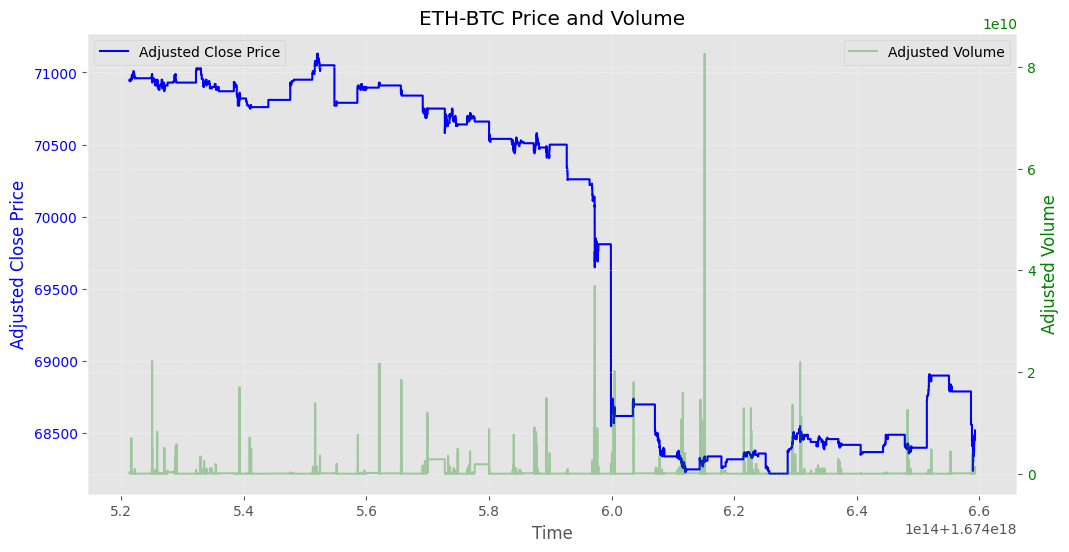

In [25]:
PlotDynamics.plot_price_volume(fr_trades_eth_btc_df, 'ETH-BTC', price_column_name='price', volume_column_name='total_volume', use_steps_post=True)

#### ETH-USD Pair Dynamics

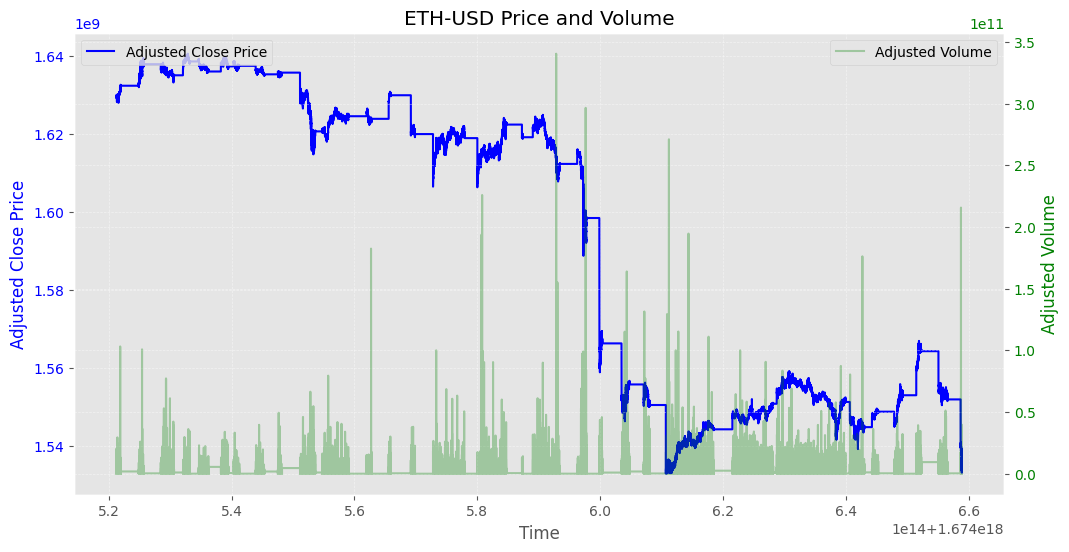

In [26]:
PlotDynamics.plot_price_volume(fr_trades_eth_usd_df, 'ETH-USD', price_column_name='price', volume_column_name='total_volume', use_steps_post=True)

### Return Dynamics

#### BTC-USD Forward Return Dynamics

In [27]:
fr_trades_btc_usd_df
fr_trades_eth_btc_df
fr_trades_eth_usd_df

,price,total_volume,5000000000.0_forward_price,5000000000.0_foward_returns
timestamp_utc_nanoseconds,,,,
1674521271071902000,"1,629,670,000.0000",11815210,"1,629,855,000.0000",0.0001
1674521271398509000,"1,629,780,000.0000",1821747820,"1,629,850,000.0000",0.0000
1674521271578052000,"1,629,770,000.0000",92150000,"1,629,850,000.0000",0.0000
1674521271660995000,"1,629,795,000.0000",613560000,"1,629,840,000.0000",0.0000
1674521271885174000,"1,629,895,000.0000",480000000,"1,629,835,000.0000",-0.0000
...,...,...,...,...
1674658830318655000,"1,533,320,000.0000",4554000080,"1,533,300,000.0000",-0.0000
1674658830318708000,"1,533,335,000.0000",7617832610,"1,533,300,000.0000",-0.0000
1674658830319185000,"1,533,310,000.0000",2095786600,"1,533,300,000.0000",-0.0000


#### BTC-USD Fowarward Return Dynamics

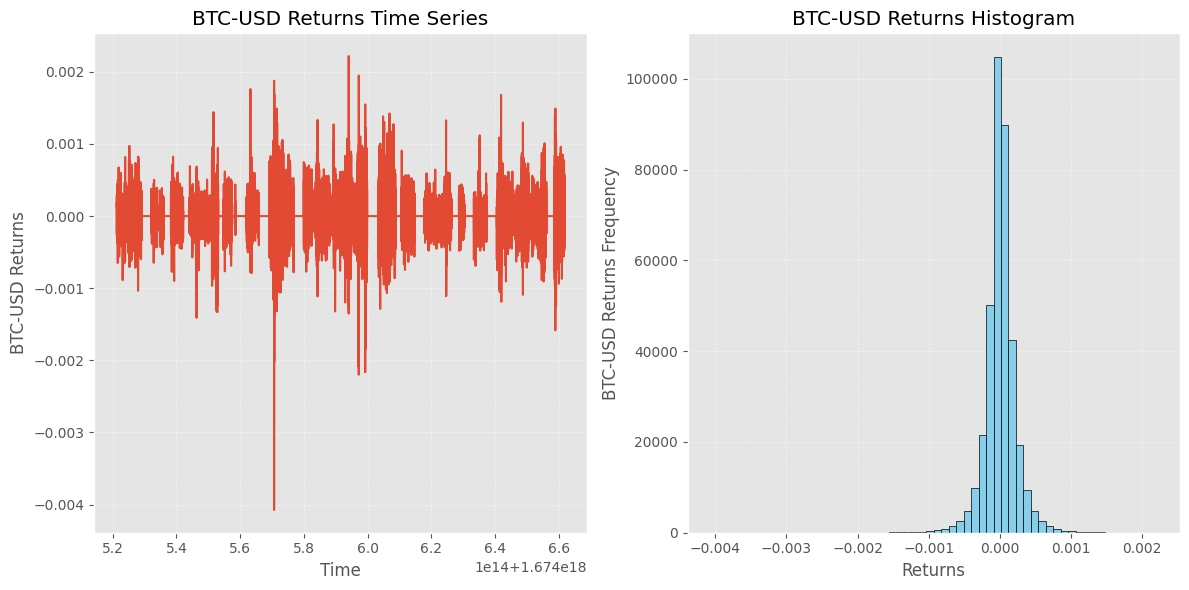

In [28]:
PlotDynamics.plot_returns_ts_hist(fr_trades_btc_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'], 'BTC-USD', bins=60, use_steps_post=True)

#### ETH-BTC Fowarward Return Dynamics

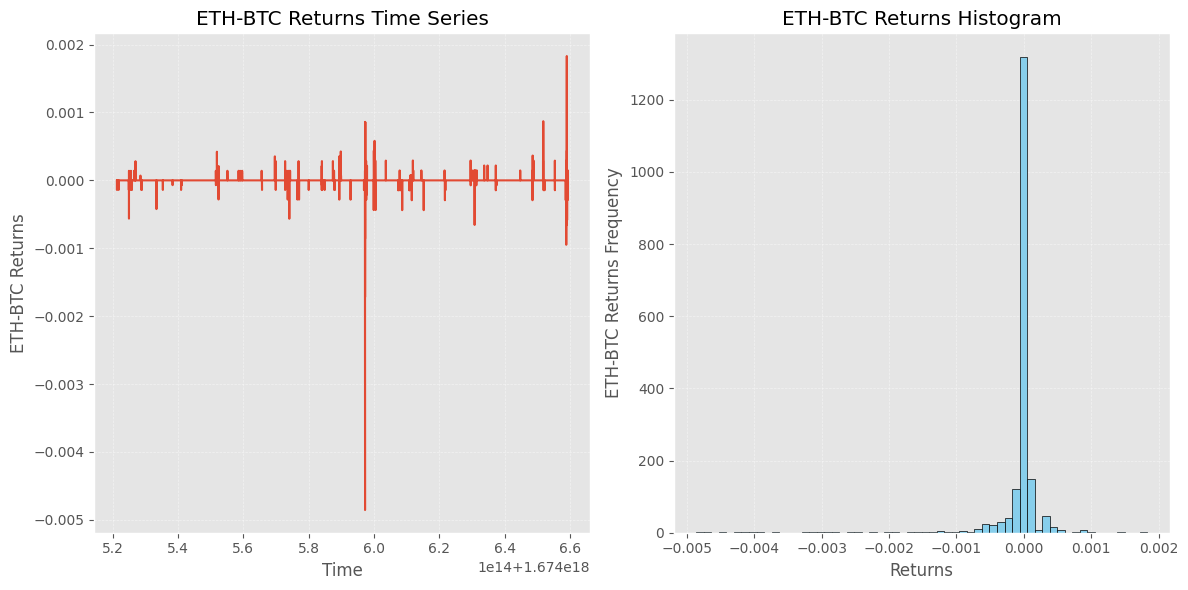

In [29]:
PlotDynamics.plot_returns_ts_hist(fr_trades_eth_btc_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'], 'ETH-BTC', bins=60, use_steps_post=True)

#### ETH-USD Fowarward Return Dynamics

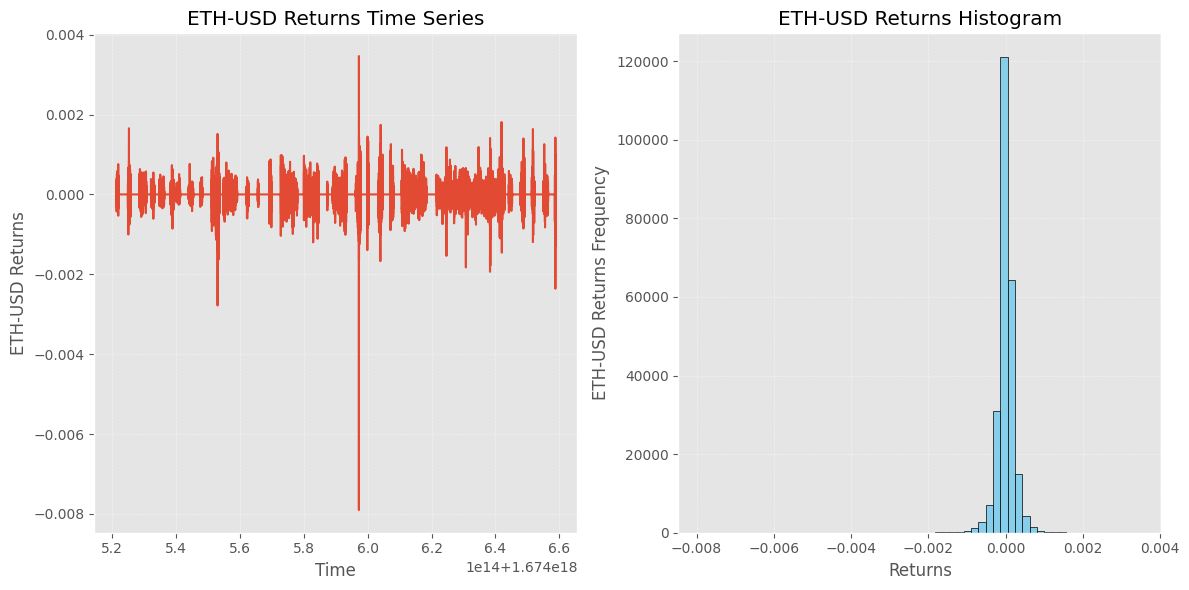

In [30]:
PlotDynamics.plot_returns_ts_hist(fr_trades_eth_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'], 'ETH-USD', bins=60, use_steps_post=True)

### Correlation

In [ ]:
scatter_matrix(
    pd.concat([
        fr_trades_btc_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
        fr_trades_eth_btc_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
        fr_trades_eth_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns']
    ], axis=1)
    , diagonal='kde'
    ) 

### Trade Flow Momentum

In [57]:
# LAGGED_TRADEFLOW_TIME = 5e9
frtf_train_trades_btc_usd_df: pd.DataFrame = Compute.forward_returns(train_trades_btc_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
frtf_train_trades_eth_btc_df: pd.DataFrame = Compute.forward_returns(train_trades_eth_btc_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
frtf_train_trades_eth_usd_df: pd.DataFrame = Compute.forward_returns(train_trades_eth_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)

frtf_train_trades_btc_usd_df = frtf_train_trades_btc_usd_df.merge(
    Compute.lagged_tradeflow(train_trades_btc_usd_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()
frtf_train_trades_eth_btc_df = frtf_train_trades_eth_btc_df.merge(
    Compute.lagged_tradeflow(train_trades_eth_btc_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()
frtf_train_trades_eth_usd_df = frtf_train_trades_eth_usd_df.merge(
    Compute.lagged_tradeflow(train_trades_eth_usd_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()

#### BTC-USD Regression: Trade Flow on Future Returns

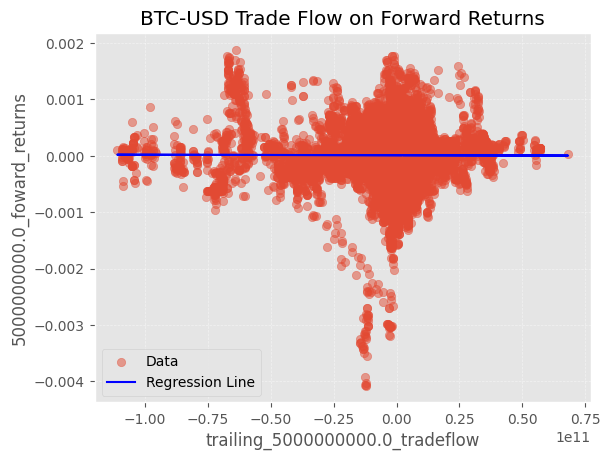

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     5000000000.0_foward_returns   R-squared:                       0.000
Model:                                     OLS   Adj. R-squared:                  0.000
Method:                          Least Squares   F-statistic:                     1.020
Date:                         Thu, 08 Feb 2024   Prob (F-statistic):              0.312
Time:                                 01:08:13   Log-Likelihood:             1.0116e+06
No. Observations:                       145003   AIC:                        -2.023e+06
Df Residuals:                           145001   BIC:                        -2.023e+06
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            5.814e-06   5.95e-07      9.777      0.000    4.65e-06    6.98e-06
trailing_5000000000.0_tradeflow -8.904e-17   8.81e-17     -1.010      0.312   -2.62e-16    8.37e-17
==============================================================================
Omnibus:                    59484.083   Durbin-Watson:                   0.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3193220.473
Skew:                          -1.201   Prob(JB):                         0.00
Kurtosis:                      25.864   Cond. No.                     6.76e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.76e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
PlotDynamics.plot_regression_statistics(
    frtf_train_trades_btc_usd_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow'],
    frtf_train_trades_btc_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
    use_bias=True,
    title='BTC-USD Trade Flow on Forward Returns'
    )

#### ETH-BTC Regression: Trade Flow on Future Returns

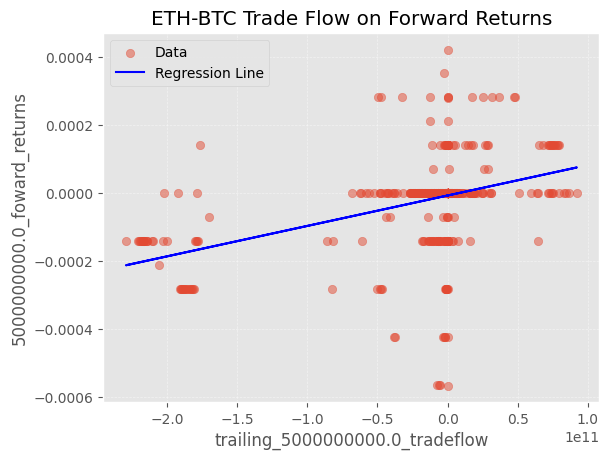

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     5000000000.0_foward_returns   R-squared:                       0.176
Model:                                     OLS   Adj. R-squared:                  0.175
Method:                          Least Squares   F-statistic:                     158.2
Date:                         Thu, 08 Feb 2024   Prob (F-statistic):           5.20e-33
Time:                                 01:08:00   Log-Likelihood:                 5800.7
No. Observations:                          741   AIC:                        -1.160e+04
Df Residuals:                              739   BIC:                        -1.159e+04
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -6.666e-06   3.64e-06     -1.833      0.067   -1.38e-05    4.72e-07
trailing_5000000000.0_tradeflow  8.947e-16   7.11e-17     12.577      0.000    7.55e-16    1.03e-15
==============================================================================
Omnibus:                      280.235   Durbin-Watson:                   0.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3197.598
Skew:                          -1.366   Prob(JB):                         0.00
Kurtosis:                      12.803   Cond. No.                     5.24e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
PlotDynamics.plot_regression_statistics(
    frtf_train_trades_eth_btc_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow'],
    frtf_train_trades_eth_btc_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
    use_bias=True,
    title='ETH-BTC Trade Flow on Forward Returns'
    )

#### ETH-USD Regression: Trade Flow on Future Returns

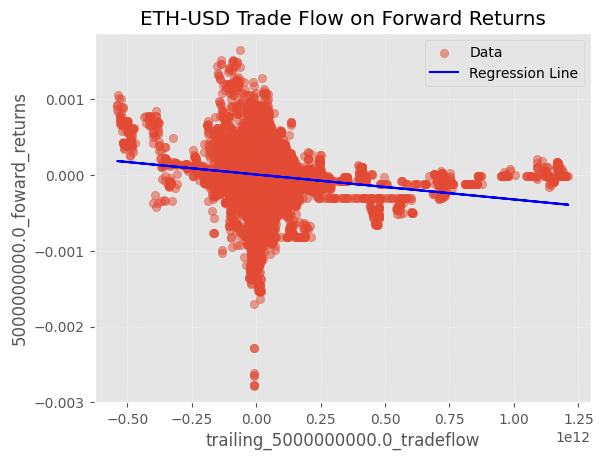

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     5000000000.0_foward_returns   R-squared:                       0.011
Model:                                     OLS   Adj. R-squared:                  0.011
Method:                          Least Squares   F-statistic:                     1114.
Date:                         Thu, 08 Feb 2024   Prob (F-statistic):          6.34e-243
Time:                                 01:08:16   Log-Likelihood:             7.0251e+05
No. Observations:                        99009   AIC:                        -1.405e+06
Df Residuals:                            99007   BIC:                        -1.405e+06
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            8.015e-06   6.38e-07     12.564      0.000    6.76e-06    9.27e-06
trailing_5000000000.0_tradeflow -3.297e-16   9.88e-18    -33.379      0.000   -3.49e-16    -3.1e-16
==============================================================================
Omnibus:                    19206.745   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           303966.439
Skew:                          -0.490   Prob(JB):                         0.00
Kurtosis:                      11.528   Cond. No.                     6.46e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [91]:
PlotDynamics.plot_regression_statistics(
    frtf_train_trades_eth_usd_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow'],
    frtf_train_trades_eth_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
    use_bias=True,
    title='ETH-USD Trade Flow on Forward Returns'
    )

## IV. Trading Strategy

In [92]:
j = 0.0001

#### Creating Testing DataFrame

In [94]:
# LAGGED_TRADEFLOW_TIME = 5e9
frtf_test_trades_btc_usd_df: pd.DataFrame = Compute.forward_returns(test_trades_btc_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
frtf_test_trades_eth_btc_df: pd.DataFrame = Compute.forward_returns(test_trades_eth_btc_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
frtf_test_trades_eth_usd_df: pd.DataFrame = Compute.forward_returns(test_trades_eth_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)

frtf_test_trades_btc_usd_df = frtf_test_trades_btc_usd_df.merge(
    Compute.lagged_tradeflow(train_trades_btc_usd_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()
frtf_test_trades_eth_btc_df = frtf_test_trades_eth_btc_df.merge(
    Compute.lagged_tradeflow(train_trades_eth_btc_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()
frtf_test_trades_eth_usd_df = frtf_test_trades_eth_usd_df.merge(
    Compute.lagged_tradeflow(train_trades_eth_usd_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()

## V.